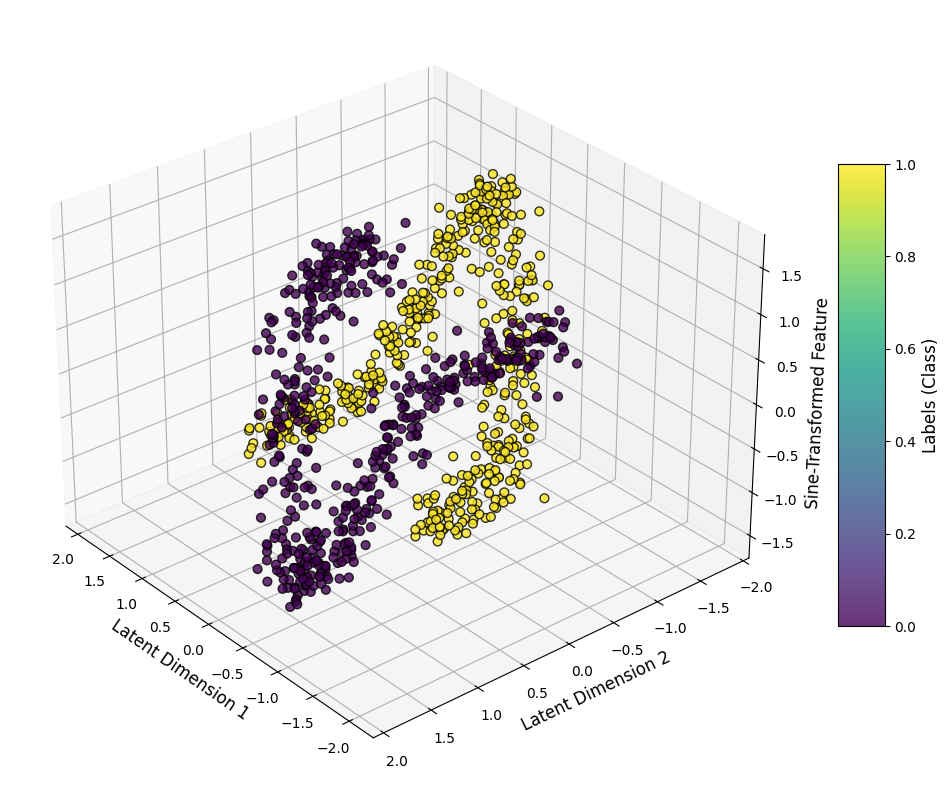

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from utils.data import generate_synthetic_data

data = generate_synthetic_data(4000, 0.1, 2)
X_train = data[0]
X_train_labels = data[1]

data_test = generate_synthetic_data(1000, 0.1, 2)
X_test = data_test[0]
X_test_labels = data_test[1]
N_train, D = X_train.shape

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d', azim=140, elev=30)
scatter = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2],
                     c=X_test_labels.ravel(), cmap='viridis', s=40, alpha=0.8, edgecolor='k')

# Customization
ax.set_xlabel("Latent Dimension 1", fontsize=12)
ax.set_ylabel("Latent Dimension 2", fontsize=12)
ax.set_zlabel("Sine-Transformed Feature", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, aspect=10)
cbar.set_label("Labels (Class)", fontsize=12)

# Styling and save
plt.tight_layout()
plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=20, latent_dim=2, dropout=0.05):
        super(VAE, self).__init__()
        # Adjusted architecture based on input dimensions
        self.input_dim = input_dim
        
        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim*2)
        self.fc1ter = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
            
        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc3bis = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc4 = nn.Linear(hidden_dim*2, input_dim)

        self.drop = nn.Dropout(p=dropout)

        
    def encode(self, x):
        h1 = self.drop(torch.nn.LeakyReLU(0.1)(self.fc1(x)))
        h1 = self.drop(torch.nn.LeakyReLU(0.1)(self.fc1ter(h1)))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        h3 = self.drop(torch.nn.LeakyReLU(0.1)(self.fc3(z)))
        h3 = self.drop(torch.nn.LeakyReLU(0.1)(self.fc3bis(h3)))
        return self.fc4(h3)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
def loss_function(recon_x, x, mu, logvar, beta):
    BCE = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta* KLD, BCE, KLD


In [3]:
from sklearn.manifold import TSNE

def visualize_results(history, latent_repr, recon, communities):
    """Visualize training results and latent space"""
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot losses
    plt.subplot(2, 3, 1)
    plt.plot(history['total_loss'], label='Total Loss')
    plt.plot(history['bce_loss'], label='BCE Loss')
    plt.plot(history['kl_loss'], label='KL Loss')
    plt.legend()
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # Visualize latent space with t-SNE
    plt.subplot(2, 3, 2)
    #tsne = TSNE(n_components=2, random_state=42)
    #z_tsne = tsne.fit_transform(latent_repr)
    
    #plt.scatter(z_tsne[:,0], z_tsne[:,1], c=communities[:,0])
    plt.scatter(latent_repr[:,0], latent_repr[:,1], c=communities[:,0])
    plt.title('Latent Space')


    ax = plt.subplot(2, 3, 3,  projection='3d', azim=140, elev=30)
    scatter = ax.scatter(recon[:, 0], recon[:, 1], recon[:, 2],
                        c=communities[:,0], cmap='viridis', s=40, alpha=0.8, edgecolor='k')

    # Customization
    ax.set_xlabel("Dimension 1", fontsize=12)
    ax.set_ylabel("Dimension 2", fontsize=12)
    ax.set_zlabel("Sine-Transformed Feature", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.title('Reconstructed')
    plt.tight_layout()
    plt.show()
    
    return plt


In [4]:
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set input dimensions
input_dim = D
latent_dim = 2
hidden_dim = 64
batch_size = 256
learning_rate = 1e-4
epochs = 2000  # Reduced for faster execution
train_dataset = TensorDataset( torch.tensor(X_train, dtype=torch.float32),  torch.tensor(X_train_labels, dtype=torch.long))
test_dataset = TensorDataset( torch.tensor(X_test, dtype=torch.float32),  torch.tensor(X_test_labels, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = VAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Using device: cpu


Starting training...
Train Epoch: 1 [0/4000 (0%)]	Loss: 5.008302, Beta: 1e-09
Train Epoch: 1 [2560/4000 (62%)]	Loss: 4.910450, Beta: 1e-09
====> Epoch: 1 Average loss: 5.0574
Train Epoch: 2 [0/4000 (0%)]	Loss: 5.036706, Beta: 8e-09
Train Epoch: 2 [2560/4000 (62%)]	Loss: 4.925867, Beta: 8e-09
====> Epoch: 2 Average loss: 4.9981
Train Epoch: 3 [0/4000 (0%)]	Loss: 4.701278, Beta: 2.7e-08
Train Epoch: 3 [2560/4000 (62%)]	Loss: 4.860900, Beta: 2.7e-08
====> Epoch: 3 Average loss: 4.9688
Train Epoch: 4 [0/4000 (0%)]	Loss: 4.762243, Beta: 6.4e-08
Train Epoch: 4 [2560/4000 (62%)]	Loss: 5.262424, Beta: 6.4e-08
====> Epoch: 4 Average loss: 4.9398
Train Epoch: 5 [0/4000 (0%)]	Loss: 4.862451, Beta: 1.2500000000000002e-07
Train Epoch: 5 [2560/4000 (62%)]	Loss: 4.754064, Beta: 1.2500000000000002e-07
====> Epoch: 5 Average loss: 4.8836
Train Epoch: 6 [0/4000 (0%)]	Loss: 5.053037, Beta: 2.16e-07
Train Epoch: 6 [2560/4000 (62%)]	Loss: 4.793897, Beta: 2.16e-07
====> Epoch: 6 Average loss: 4.7517
Train E

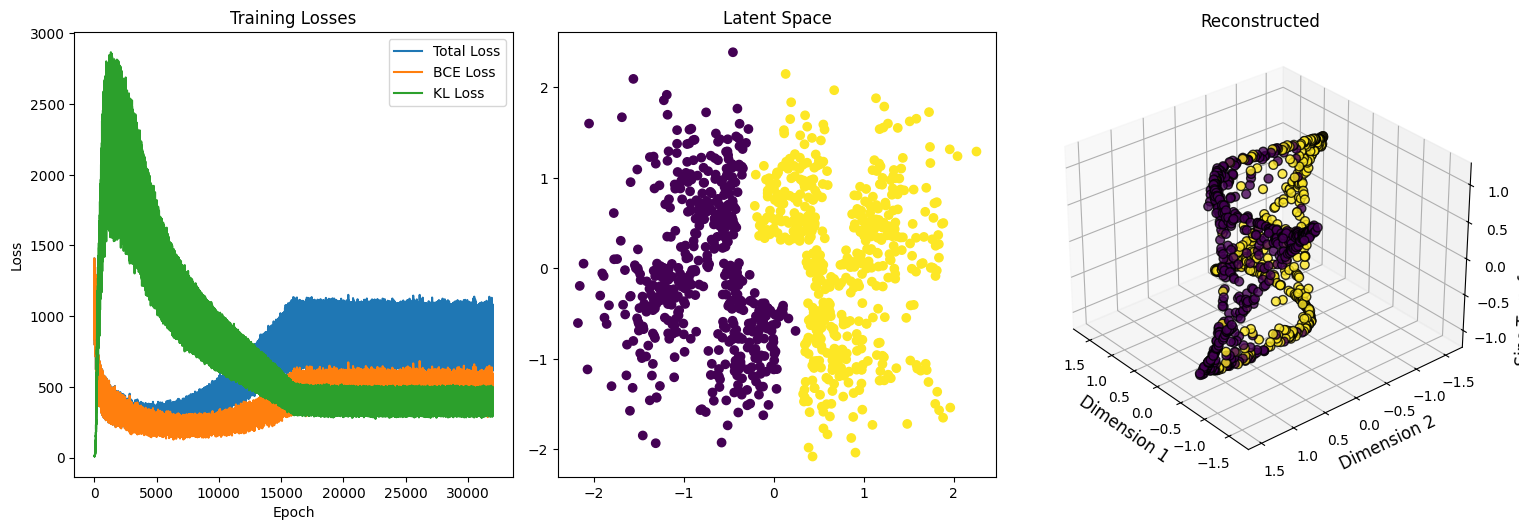

Training complete.


In [5]:
# Main execution
print("Starting training...")
history = {
        'total_loss': [],
        'bce_loss': [],
        'kl_loss': []
}
model.train()
for epoch in range(1, epochs + 1):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        beta = min(1.0, (epoch / (epochs*0.5))**3)
        loss, bce, kld = loss_function(recon_batch, data, mu, logvar, beta)
        history['total_loss'].append(float(loss))
        history['bce_loss'].append(float(bce))
        history['kl_loss'].append(float(kld))
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}, Beta: {beta}')
    
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
# Visualize some reconstructed data
model.eval()
all_latents = []
all_recons = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        latent_mu = model.encode(data)[0]
        recon = model.forward(data)[0]         
        
        all_latents.append(latent_mu.cpu())
        all_recons.append(recon.cpu())
        all_labels.append(labels.cpu())

# Concatenate everything into full tensors
all_latents = torch.cat(all_latents, dim=0)
all_recons = torch.cat(all_recons, dim=0)
all_labels = torch.cat(all_labels, dim=0)


visualize_results(history,all_latents, all_recons, all_labels.numpy())

print("Training complete.")



In [6]:
from utils.manifolds.visuals import *
from utils.manifolds.core import *

def metric(z):
    return decoder_point_metric(model, z)

n_dimensions = 2
data = latent_mu.numpy()[:10,:]
print("Computing distance matrix...")
dist = create_riemannian_distance_matrix(data, metric)
print("Visualizing...")
visualize_manifold_embedding(data,dist )


Computing distance matrix...


Calculating distances:   0%|          | 0/45 [00:00<?, ?it/s]

Error at grid point ([-1.00134921 -0.11822054]): tuple index out of range


LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

/var/folders/qc/fbm2wz190nqd87d2mq7l90_80000gn/T/ipykernel_37229/2340668194.py:318: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  label_cmap = plt.cm.get_cmap('tab10', len(unique_labels))


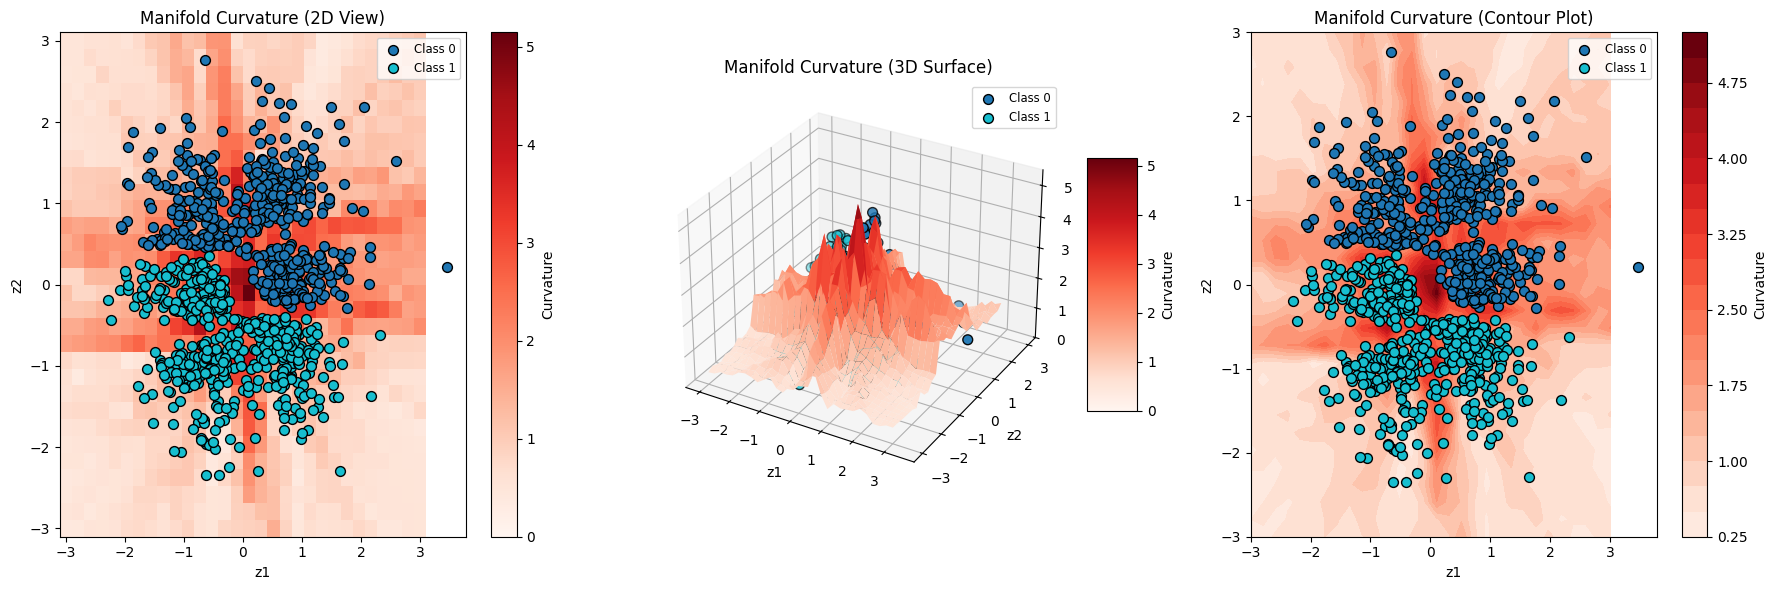

In [ ]:
curvature, Z1, Z2 = visualize_manifold_curvature(metric, data_points=all_latents.numpy(), labels=all_labels.squeeze(1).numpy())
start_point = np.array([-1.5, -1.5])
end_point = np.array([1.5, 1.5])
plot_geodesics(metric, start_point, end_point, curvature, Z1, Z2)
plot_geodesic_grid(metric, curvature, Z1, Z2)

Epoch 20/5000, Loss: -14.4507
Epoch 40/5000, Loss: -16.8794
Epoch 60/5000, Loss: -19.3081
Epoch 80/5000, Loss: -21.7368
Epoch 100/5000, Loss: -24.1655
Epoch 120/5000, Loss: -26.5942
Epoch 140/5000, Loss: -29.0229
Epoch 160/5000, Loss: -31.4516
Epoch 180/5000, Loss: -33.8803
Epoch 200/5000, Loss: -36.3090
Epoch 220/5000, Loss: -38.7377
Epoch 240/5000, Loss: -41.1664
Epoch 260/5000, Loss: -43.5951
Epoch 280/5000, Loss: -46.0238
Epoch 300/5000, Loss: -48.4524
Epoch 320/5000, Loss: -50.8811
Epoch 340/5000, Loss: -53.3098
Epoch 360/5000, Loss: -55.7385
Epoch 380/5000, Loss: -58.1671
Epoch 400/5000, Loss: -60.5958
Epoch 420/5000, Loss: -63.0245
Epoch 440/5000, Loss: -65.4532
Epoch 460/5000, Loss: -67.8818
Epoch 480/5000, Loss: -70.3105
Epoch 500/5000, Loss: -72.7392
Epoch 520/5000, Loss: -75.1679
Epoch 540/5000, Loss: -77.5965
Epoch 560/5000, Loss: -80.0252
Epoch 580/5000, Loss: -82.4539
Epoch 600/5000, Loss: -84.8826
Epoch 620/5000, Loss: -87.3113
Epoch 640/5000, Loss: -89.7399
Epoch 660/50

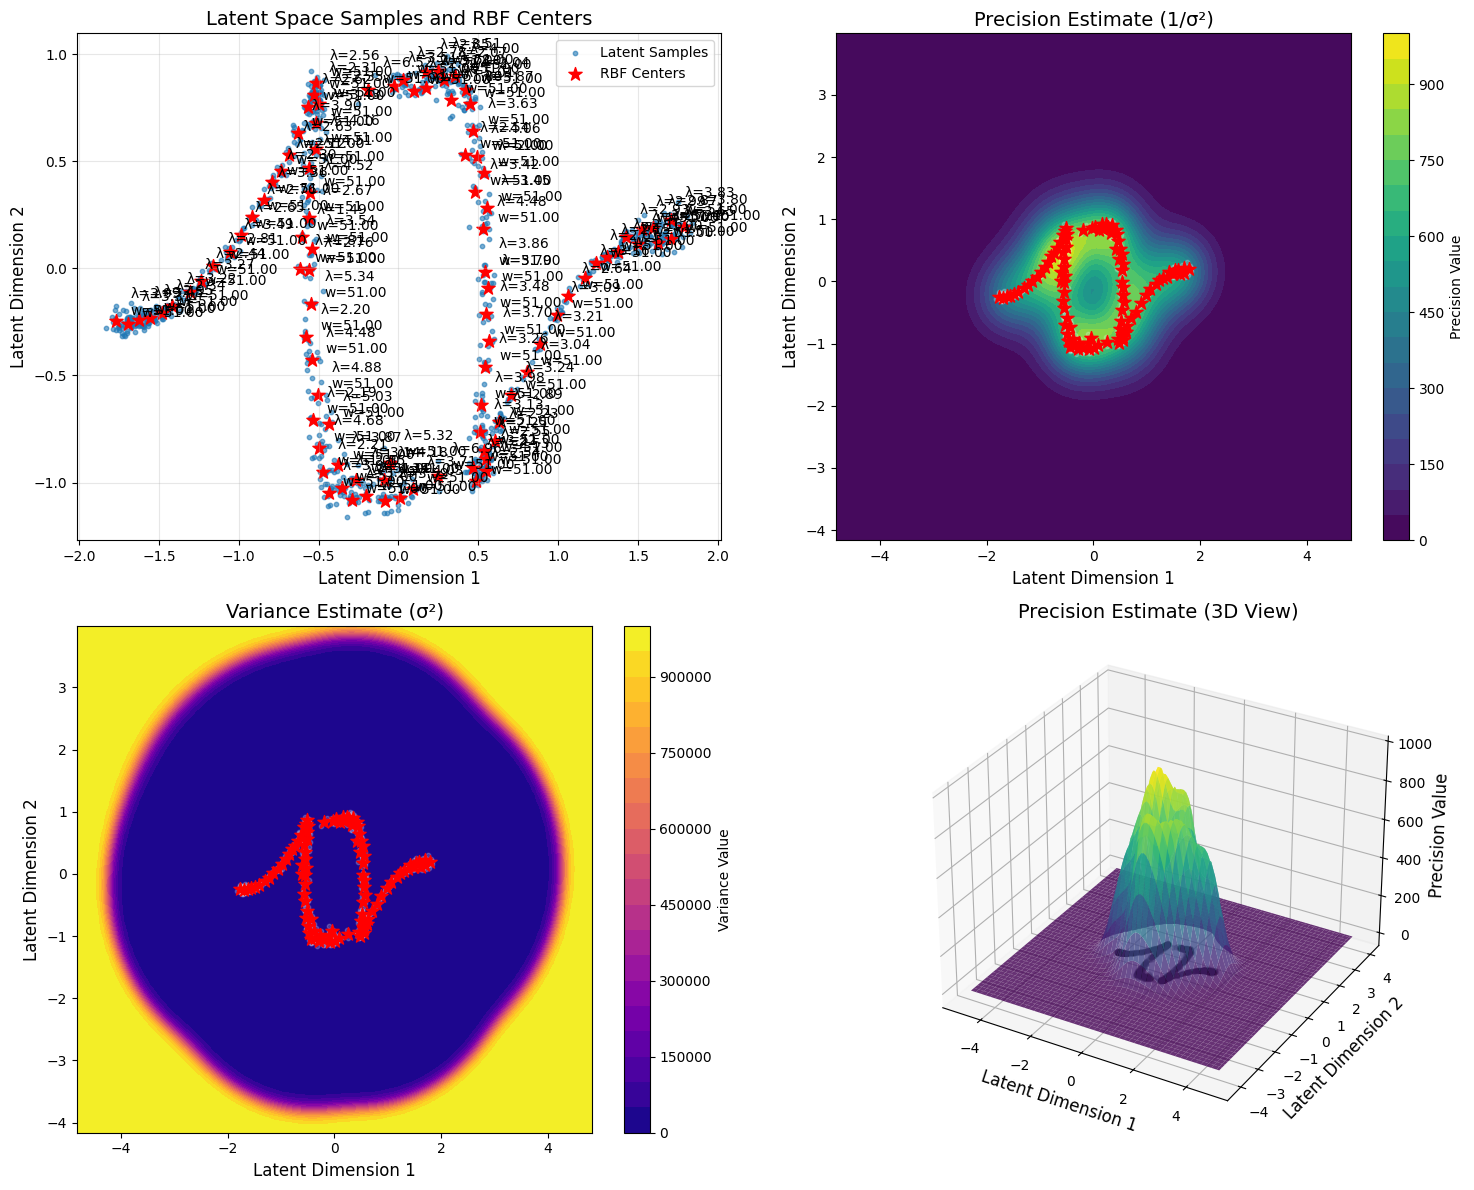

In [ ]:
from utils.models.rbf import visualize_2dlatent_space_precision

fig, model = visualize_2dlatent_space_precision(
        latent_samples=all_latents,
        n_centers=100,  
        a=200,        # Controls bandwidth scaling
        optimize_weights=True,  # Whether to optimize the weights
        n_epochs= 5000
    )
    
plt.show()